# Import Required Libraries

In [95]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import numpy as np
from xgboost import XGBClassifier

In [96]:
df=pd.read_csv(r"weatherAUS.csv") # ,parse_dates=True

In [97]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [98]:
df.index.dtype

dtype('int64')

# Get rid of null(NA) target column values and use them to test our model later

AxesSubplot(0.125,0.125;0.775x0.755)


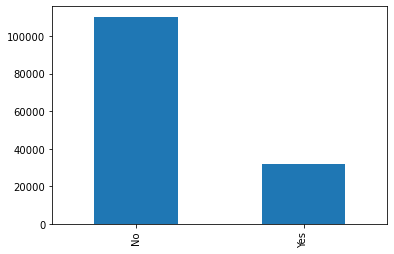

In [99]:
test=df[df.RainToday.isna()|df.RainTomorrow.isna()]
labels=df[~((df.RainToday.isna())|(df.RainTomorrow.isna()))].RainTomorrow
train=df[~((df.RainToday.isna())|(df.RainTomorrow.isna()))].drop(["RainTomorrow","Date"],axis=1) # Date is not relevent and will cause high runtime when OneHot encoded
print(df.RainTomorrow.value_counts().plot(kind="bar"))

# Methods of Imputation

## 1.   Imputing by average value

In [100]:
def impute_by_mean(df,cols: list):
    for i in cols:
        print(i)
        avg=df[i].mean()
        df[i].fillna(value=avg,inplace=True)

## 2.   Imputing by median value

In [101]:
def impute_by_median(df,cols: list):
    for i in cols:
        print(i)
        avg=df[i].median()
        df[i].fillna(value=avg,inplace=True)

## 3.   Imputing by mode value (can be used for both categorical and numerical columns)

In [102]:
def impute_by_mode(df,cols: list):
    for i in cols:
        print(i)
        avg=df[i].mode()
        df[i].fillna(value=avg,inplace=True)

# Perform Imputation and find categorical columns for OneHot encoding later(Optional)

In [103]:
d = (train.dtypes == 'float64')
float_cols = list(d[d].index)
s = (train.dtypes == 'object')
object_cols = list(s[s].index)
#impute_by_mean(train,float_cols)
impute_by_median(train,float_cols)
impute_by_mode(train,object_cols)
X_train,X_val,y_train,y_val=train_test_split(train,labels,train_size=0.95)

print("All categorical columns")
print(object_cols) 

print(X_train[float_cols].isna().sum().sum())
print(X_val[float_cols].isna().sum().sum())
print(y_val.isna().sum().sum())
print(y_train.isna().sum().sum())
# Only the columns with categorical values have NA values, so OneHot Encoding remains

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
Location
WindGustDir
WindDir9am
WindDir3pm
RainToday
All categorical columns
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
0
0
0
0


# OneHot encoding

In [104]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# OneHot encode the training and val dataset categorical columns
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
# Restore the columns names after OneHot encoding
OH_cols_train.columns = OH_encoder.get_feature_names()
OH_cols_val = pd.DataFrame(OH_encoder.transform(X_val[object_cols]))
OH_cols_val.columns = OH_encoder.get_feature_names()
# OneHot encode our 1D Target feratures
final_y_train= pd.DataFrame(OH_encoder.fit_transform(pd.DataFrame(y_train)))
final_y_train.columns = OH_encoder.get_feature_names()
final_y_val= pd.DataFrame(OH_encoder.transform(pd.DataFrame(y_val)))
final_y_val.columns = OH_encoder.get_feature_names()
# Restore lost index series to to all data
final_y_train.index=y_train.index
final_y_val.index=y_val.index
OH_cols_train.index=X_train.index
OH_cols_val.index=X_val.index
# Restore the columns names after OneHot encoding


# Drop old categorical columns and concat with the OneHot encoded dataframe
#print(X_train.head())
X_train=X_train.drop(object_cols,axis=1)
#print(X_train.head())
X_val=X_val.drop(object_cols,axis=1)
final_X_train=X_train.join(OH_cols_train)
final_X_val=X_val.join(OH_cols_val)
# Assert number of entry for coresponding predictor and target are equivalent
assert len(final_X_train)==len(final_y_train)
assert len(final_X_val)==len(final_y_val)

# Convert OneHot encoded columns to Ordinal encoding(Optional)

In [105]:
def arg(l):
    arr=[]
    for i in l.values.tolist():
        arr.append(np.argmax(i))
    return np.array(arr)

In [106]:
def arg2(l):
    arr=[]
    for i in l:
        arr.append(np.argmax(i))
    return np.array(arr)

# Examples of ML models

## 1.   RandomForest with OneHot encoding

In [107]:
def score_dataset_RandomForest_OneHot(X_train, X_valid, y_train, y_valid,n):
    model = RandomForestClassifier(n_estimators=n, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

## 2.   RandomForest

In [108]:
def score_dataset_RandomForest(X_train, X_valid, y_train, y_valid,n):
    model = RandomForestClassifier(n_estimators=n, random_state=0)
    model.fit(X_train, arg(y_train))
    preds = model.predict(X_valid)
    return accuracy_score(arg(y_valid), arg2(preds))

## 3.   XGB

In [109]:
def score_dataset_XGB(X_train, X_valid, y_train, y_valid,n):
    model = XGBClassifier(n_estimators=n, random_state=0,use_label_encoder=False)
    model.fit(X_train, arg(y_train))
    preds = model.predict(X_valid)
    print(len(preds))
    return accuracy_score(arg(y_valid), arg2(preds))

## 4.   Gradient Boosting

In [110]:
def score_dataset_GradientBoosting(X_train, X_valid, y_train, y_valid,n):
    model = GradientBoostingClassifier(n_estimators=n, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

# Train the model and evaluate

In [112]:
n=100
print("{}% for {} estimators.".format(round(score_dataset_RandomForest_OneHot(final_X_train,final_X_val,final_y_train,final_y_val,n),3)*100,n))

85.3% for 100 estimators.
